# PyTorch Workflow

One of the workflows when using PyTorch for doing ML is as follows:  
- → preprocessing raw data  
- → Dataset class 
- → DataLoader
- → Model (nn.Module)
- → Loss function
- → Optimizer
- → Training loop
- → Validation loop
- → Metrics + plots
- → Physical interpretation


## 1. Data Processing (and Loading)

To start up with this, we jump into a linear regression model, with **known** parameters

In [2]:
import torch 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# start with known params
weight = 0.7    
bias = 0.3

start, stop, step = 0, 1, 0.02
X = torch.arange(start, stop, step).unsqueeze(dim=1) 
# what unsqueeze does is that it changes it from a 1D 
# vector along the row to a sort of Nx1 matrix for easy multiplication

y = weight * X + bias # This creates our datasets of sort

### Splitting data into training and test sets

The split is as follows: 
| Split | Yeh kya hai | %age |
|-------|-------------|------|
|Training Set|Used for training the model, sort of like course material|60-80%|
|Validation Set|Model gets tuned to this data, sort of like the practice exams|10-20%|
|Test Set|Model is finally tested on this data, like the exams given to us|10-20%|

In [4]:
# Now for the splitting
train_num = int(0.8 * len(X))
X_train, y_train = X[:train_num], y[:train_num]
X_test, y_test = X[train_num:], y[train_num:]

# And now for the visualization
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    plt.legend(prop={"size":14})

## 1.1. DataLoader

Right now, considering that our data is in the form of Python datasets, we must convert them into a Python iterable. Or more specifically group them into batches (or mini-batches)

In [5]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 32

# Now creating the training and testing iterables (dataloaders)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
# No need to shuffle test datasets even if there is order
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)


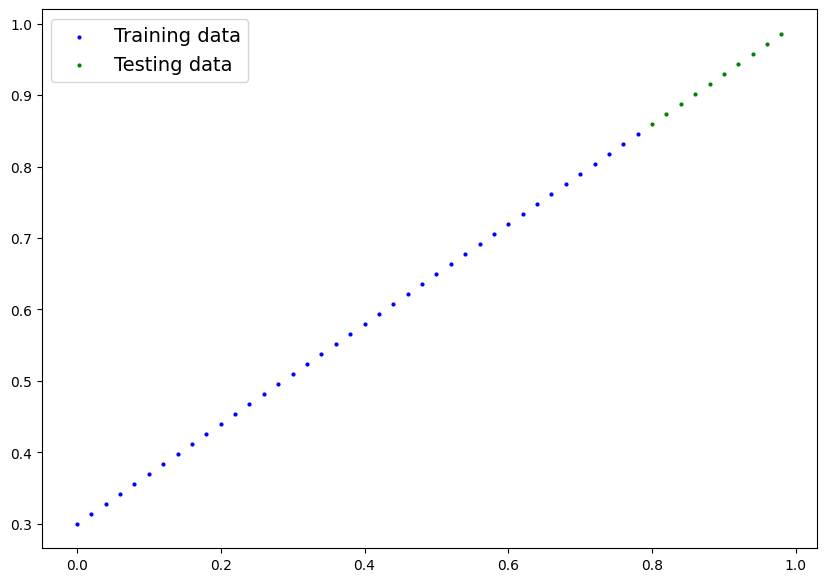

In [6]:
plot_predictions()

## 2. Building a PyTorch Model
We do end up using Python classes for this, so if required, go look it up.

In [7]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.nn.Parameter(torch.randn(1,                      # starting with randomly assigned weight
                                                      requires_grad=True,     # using gradient descent to work out the weight
                                                      dtype=torch.float))
        self.bias = torch.nn.Parameter(torch.randn(1, 
                                                   requires_grad=True, 
                                                   dtype=torch.float))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

**Note**  
all `nn.Module` subclasses requires you to overwrite `def forward()`. This method defines what happens in the forward computation  
  
There are also 2 useful tools that will come in handy later for more important goals:  
- `torch.utils.data.Dataset`
- `torch.utils.data.DataLoader`  


In [8]:
# Assigning the model class to a variable
model_0 = LinearRegressionModel()

list(model_0.parameters()) # Returns the random initialized parameters

[Parameter containing:
 tensor([1.2197], requires_grad=True),
 Parameter containing:
 tensor([0.3037], requires_grad=True)]

#### Making Predictions using `torch.inference_mode()`

`torch.inference_mode()` is important because it doesn't store the gradient data and turns off a lot of things which are important during training but useless during inference and are otherwise carried by the parameters. This makes the code much faster especially when there are 1000's of parameters to adjust.

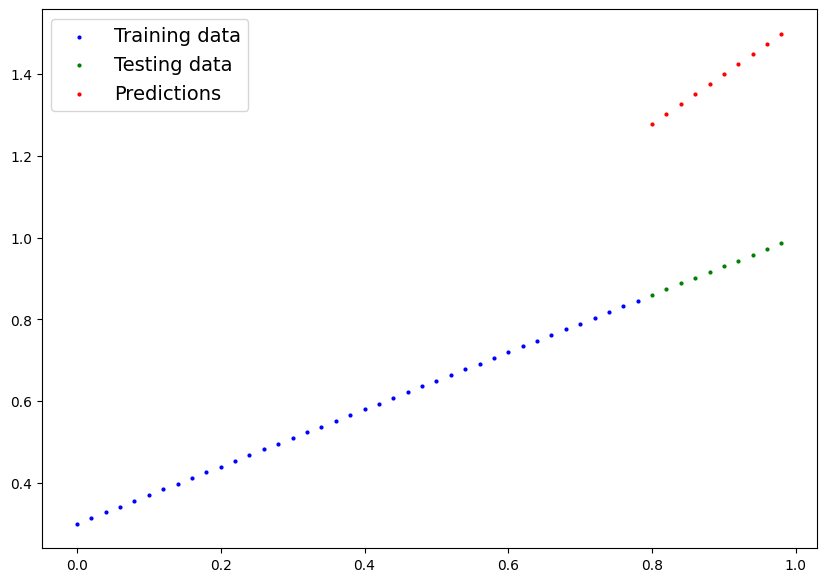

In [9]:
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

## 3. Training  
As usual best way to do it is dynamically  

### Using Loss Functions and Optimizers
| Function | Where it lives? | Common types |
|----------|-----------------|--------------|
|Loss Function|in `torch.nn`|Mean Absolute Error: `torch.nn.L1Loss()` (Regression models) <br> Binary Cross Entropy: `torch.nn.BCELoss()` (Classification models)|
|Optimizer|in `torch.optim`|Stochastic Gradient Descent: `torch.optim.SGD()` <br> Adam optimizer: `torch.optim.Adam()`|  
  
For our case, let's use MAE and SGD as lf and optims accordingly  
`torch.optim.SGD(params, lr)` is what we use for SGD where:  
- params are our parameters say weights and bias
- lr is the learning rate -> hyperparameter which we have to set ourself (typically 0.0001, 0.001, 0.01)

In [10]:
# Setting up the Loss function
loss_fn = torch.nn.L1Loss() # Mean Absolute Error

# Setting up the Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.001) # Stochastic Gradient Descent

### Procedure to follow during training
0. Loop through the data (WHY?)
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward - *back propagation algorithm*
5. Optimizer step - Now use optimizer to adjust the model's parameters to minimize loss

In [11]:
epochs = 3000 # Number of loops through the data (hyperparameter)
epoch_list, train_loss, test_loss_val = [], [], []

# 0.
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # Sets all the parameters that require gradients to require gradients

    # 1. Forward pass
    y_preds = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_preds, y_train)

    # 3. Zero the gradients
    optimizer.zero_grad() # Prevents the accumulation of gradients from previous step 5s

    # 4. Backward propagation on the loss with respect to the parameters of the model
    loss.backward() 

    # 5. Step the optimizer (update the parameters)
    optimizer.step()

    model_0.eval()
    
    # Print out the loss every 10 epochs
    if epoch % 50 == 0:
        # Testing mode
        with torch.inference_mode():

            test_pred = model_0(X_test)
            test_loss = loss_fn(test_pred, y_test)
        
        print(f"Epoch: {epoch} | Loss: {loss.item():.4f} | Test Loss: {test_loss}")
        epoch_list.append(epoch)
        train_loss.append(loss)
        test_loss_val.append(test_loss)


Epoch: 0 | Loss: 0.2064 | Test Loss: 0.4648492932319641
Epoch: 50 | Loss: 0.1598 | Test Loss: 0.4037092626094818
Epoch: 100 | Loss: 0.1297 | Test Loss: 0.353369802236557
Epoch: 150 | Loss: 0.1106 | Test Loss: 0.31251081824302673
Epoch: 200 | Loss: 0.0985 | Test Loss: 0.2798619866371155
Epoch: 250 | Loss: 0.0908 | Test Loss: 0.2539973258972168
Epoch: 300 | Loss: 0.0858 | Test Loss: 0.23365159332752228
Epoch: 350 | Loss: 0.0823 | Test Loss: 0.21745388209819794
Epoch: 400 | Loss: 0.0797 | Test Loss: 0.20487911999225616
Epoch: 450 | Loss: 0.0775 | Test Loss: 0.19490785896778107
Epoch: 500 | Loss: 0.0755 | Test Loss: 0.18600638210773468
Epoch: 550 | Loss: 0.0737 | Test Loss: 0.1795462816953659
Epoch: 600 | Loss: 0.0719 | Test Loss: 0.1740357130765915
Epoch: 650 | Loss: 0.0702 | Test Loss: 0.16852512955665588
Epoch: 700 | Loss: 0.0685 | Test Loss: 0.16301453113555908
Epoch: 750 | Loss: 0.0667 | Test Loss: 0.1575039178133011
Epoch: 800 | Loss: 0.0650 | Test Loss: 0.15199331939220428
Epoch: 85

In [12]:
print(list(model_0.parameters()))

with torch.inference_mode():
    y_preds_new = model_0(X_test)

[Parameter containing:
tensor([0.7007], requires_grad=True), Parameter containing:
tensor([0.3003], requires_grad=True)]


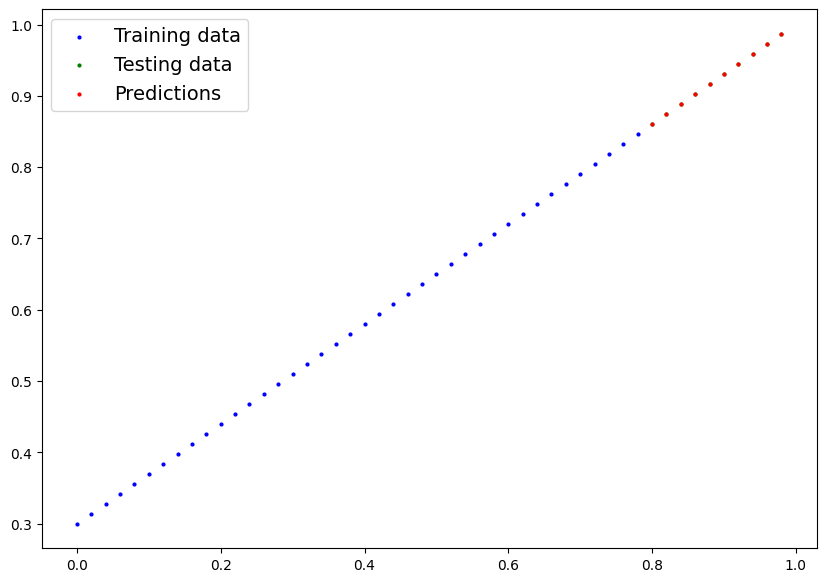

In [13]:
plot_predictions(predictions=y_preds_new)

/tmp/ipykernel_5995/1425487261.py:1: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  plt.plot(epoch_list, np.array(torch.tensor(train_loss).numpy()), label="Training Loss")


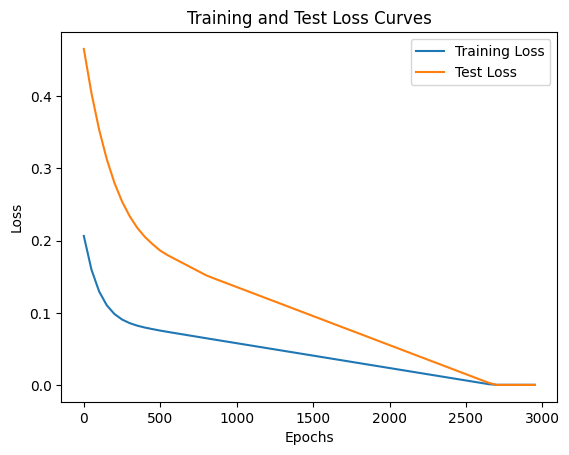

In [14]:
plt.plot(epoch_list, np.array(torch.tensor(train_loss).numpy()), label="Training Loss")
plt.plot(epoch_list, test_loss_val, label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


### Saving a model in PyTorch

There are 3 main methods for saving and loading models in PyTorch:
1. `torch.save()` which saves the models in Python's pickle format 
2. `torch.load()` which loads the models
3. `torch.nn.Module.load_state_dict()` which loads the module in dictionary format

It's always better to save as the `state_dict` rather than the entire model as we only need the parameter data  
Always best to __Save__ it as:  
`torch.save(model.state_dict(), PATH)`  
and to load __Load__, follow:
```
model = ModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```

__Slightly more advanced (optional, but good)__

For real experiments, save **more than just weights**:

```python
torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "epoch": epoch,
    "loss": loss
}, "checkpoint.pth") 
```

In [15]:
# Rather than simply saving the entire model itself we rather start by practicing saving the dictionary values alone.

torch.save({"model_state" : model_0.state_dict(),
            "optimizer_state" : optimizer.state_dict(),
            "epoch" : epoch,
            "loss" : loss 
}, "ntbk_models/test_model_checkpoint.pth")


In [16]:
# Now to load a model
loaded_model = LinearRegressionModel()

model_dict = torch.load(f="ntbk_models/test_model_checkpoint.pth")

loaded_model.load_state_dict(model_dict["model_state"])
optimizer.load_state_dict(model_dict["optimizer_state"])


#loaded_model.load_state_dict(torch.load("ntbk_models/test_model_2.pth"))

In [17]:
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

loaded_model_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Writing device-agnostic code
  
Check this site out on details regarding optimization on GPUs:
https://horace.io/brrr_intro.html

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Loss Curves 
One of the most useful tools to troubleshoot our models

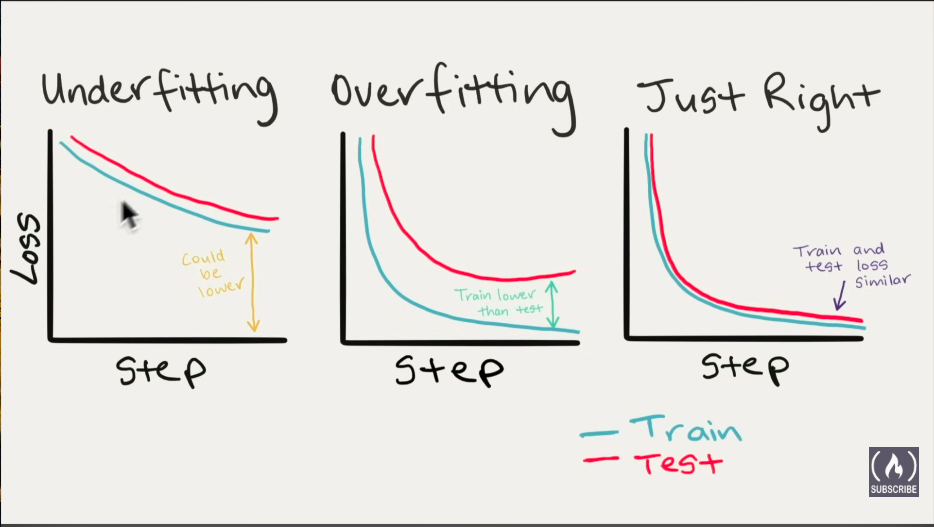

In [20]:
from IPython.display import Image, display

display(Image(filename="./ntbk_imgs/Screenshot from 2026-02-10 01-25-52.png"))


__Novel ways to deal with Overfitting__
- Data Augmentation
- Setting up an *optimizer scheduler*
- Early stopping

__Novel ways to deal with Underfitting__
- Use less regularization
- Transfer learning